# 1. Define the Background Segmentation Model

In [1]:
import tensorflow as tf
import numpy as np
import cv2
from matplotlib import pyplot as plt

E:\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Prerequisites
image_height = 240
image_width = 320
num_bin = 20+1
bin_width = 1.0/(num_bin-1)
num_training_frame = 20

In [3]:
class FuzzyHistogramModel():
    """Class to load deeplab model and run inference."""

    def __init__(self):
        """Creates and loads pretrained deeplab model."""
        self.graph = tf.Graph()
        self.sess = tf.Session(graph=self.graph)
        with self.graph.as_default():
            self.model_scope = tf.variable_scope('model', reuse=tf.AUTO_REUSE)
            self.input_scope = tf.variable_scope('input', reuse=tf.AUTO_REUSE)
            with self.model_scope:
                # Define the model
                self.fuzzy_histogram = tf.get_variable('fuzzy_histogram',
                                                  shape=[image_height, image_width, num_bin],
                                                  initializer=tf.constant_initializer(1.0),
                                                  trainable=False)
                # Intermitent constants
                self.indexing_constant = tf.constant([[[r,c] for c in range(image_width)] for r in range(image_height)],
                                                name='indexing_constant')
            with self.input_scope:
                # Define the input image
                self.input_image = tf.placeholder(tf.float32, 
                                             shape=[image_height,image_width], 
                                             name='image')
                # Define the synthesis result
                self.synthesis_result = tf.placeholder(tf.float32, 
                                                  shape=[image_height,image_width], 
                                                  name='synthesis_result')
                # Define the training flag
                self.training_flag = tf.placeholder(tf.bool, 
                                                    shape=[], 
                                                    name='training_flag')
            
            self.define_histogram_checking_ops()
            self.define_update_weight_calculation_ops()
            self.define_update_histogram_ops()
            
            
    # Initialization
    def initialize_sess(self):
        with self.graph.as_default():
            self.sess.run(tf.global_variables_initializer())
    
    # Define histogram checking
    def define_histogram_checking_ops(self):
        with self.graph.as_default():
            self.data_position_in_histogram = self.input_image/bin_width
            self.pre_index = tf.to_int32(tf.floor(self.data_position_in_histogram))
            self.pre_weight = self.data_position_in_histogram-tf.to_float(self.pre_index)
            self.next_index = self.pre_index+1
            self.next_weight = tf.to_float(self.next_index)-self.data_position_in_histogram
            self.raw_segmentation = tf.add(tf.multiply(tf.gather_nd(self.fuzzy_histogram,
                                                                    tf.concat([self.indexing_constant,tf.expand_dims(self.pre_index, -1)], -1)),
                                                       self.pre_weight),
                                           tf.multiply(tf.gather_nd(self.fuzzy_histogram,
                                                                    tf.concat([self.indexing_constant,tf.expand_dims(self.next_index, -1)], -1)),
                                                       self.next_weight), 
                                           name='raw_segmentation_calculation')
    
    def histogram_checking(self,gray_float_image):
        '''
        Inputs:
            data_to_check: [height, width], float (from 0.0 to 1.0)
            histogram_to_use: [height, width, num_bins], float
        Outputs:
            result: [height, width], float
        '''
        with self.graph.as_default():
            raw_segmentation_in_np_in_float = self.sess.run(self.raw_segmentation, feed_dict={self.input_image: gray_float_image})
        return raw_segmentation_in_np_in_float
        
    # Define fake_synthesis_generate
    def fake_synthesis_generate(self,raw_segmentation_in_np_in_float):
        # The following can be replaced by avr_pooling
        raw_segmentation_in_np_in_float_scaled_to_255 = 255.0*raw_segmentation_in_np_in_float
        raw_segmentation_in_np_in_uint8 = raw_segmentation_in_np_in_float_scaled_to_255.astype('uint8')
        blurred_mask_uint8 = cv2.medianBlur(raw_segmentation_in_np_in_uint8,9)
        blurred_mask_float = blurred_mask_uint8.astype('float')/256
        return blurred_mask_float
        
    # Define fake_synthesis_generate
    def define_update_weight_calculation_ops(self):
        # a*y^5/(x+b) a = 0.0792; b = 0.1585
        with self.graph.as_default():
            self.update_mask = (1-tf.to_float(self.training_flag))*tf.divide(0.0792*self.synthesis_result**5,self.raw_segmentation+0.1585,name='update_weight_calculation')+tf.to_float(self.training_flag)
    
    # Define update_histogram 
    def define_update_histogram_ops(self):
        with self.graph.as_default():
            self.fuzzy_histogram_add_pre = self.fuzzy_histogram + tf.sparse_tensor_to_dense(tf.SparseTensor(indices=tf.reshape(tf.to_int64(tf.concat([self.indexing_constant, tf.expand_dims(self.pre_index, -1)], -1)),
                                                                                                                               [image_height*image_width,3]), 
                                                                                            values=tf.reshape(tf.multiply(self.pre_weight,self.update_mask),
                                                                                                              [image_height*image_width,]), 
                                                                                            dense_shape=[image_height,image_width,num_bin]))
            self.fuzzy_histogram_add_next = self.fuzzy_histogram_add_pre + tf.sparse_tensor_to_dense(tf.SparseTensor(indices=tf.reshape(tf.to_int64(tf.concat([self.indexing_constant, tf.expand_dims(self.next_index, -1)], -1)),
                                                                                                                     [image_height*image_width,3]), 
                                                                                                     values=tf.reshape(tf.multiply(self.next_weight,self.update_mask),
                                                                                                                       [image_height*image_width,]), 
                                                                                                     dense_shape=[image_height,image_width,num_bin]))
            self.max_bin_value = tf.reduce_max(self.fuzzy_histogram_add_next,axis=-1)
            self.fuzzy_histogram_updated = tf.divide(self.fuzzy_histogram_add_next,
                                                     tf.tile(tf.expand_dims(self.max_bin_value, -1),
                                                             [1, 1, num_bin]), 
                                                     name='fuzzy_histogram_update')
        
    def update_histogram(self,gray_float_image,synthesis_map,train_flag):
        with self.graph.as_default():
            new_hist = self.sess.run(self.fuzzy_histogram_updated, feed_dict={self.input_image: gray_float_image, 
                                                                              self.synthesis_result: synthesis_map,
                                                                              self.training_flag: train_flag})
            self.fuzzy_histogram.load(new_hist,self.sess)
    
    def write_graph(self,log_path):
        with self.graph.as_default():
            tf.summary.FileWriter(log_path, self.sess.graph)
    
    def __del__(self):
        self.sess.close()

## 1.1. Test the fuzzy histogram based background model

In [4]:
image_folder = 'F:\\dataset2014\\dataset\\baseline\\highway\\input\\'

In [5]:
FH_MODEL = FuzzyHistogramModel()

In [6]:
with FH_MODEL.graph.as_default():
    for var in tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES ):
        print(var.name,var.shape)
    print(FH_MODEL.indexing_constant)
    for op in tf.get_default_graph().get_operations():
        if op.type == "Placeholder":
            print(op.get_attr)

model/fuzzy_histogram:0 (240, 320, 21)
Tensor("model/indexing_constant:0", shape=(240, 320, 2), dtype=int32)
<bound method Operation.get_attr of <tf.Operation 'input/image' type=Placeholder>>
<bound method Operation.get_attr of <tf.Operation 'input/synthesis_result' type=Placeholder>>
<bound method Operation.get_attr of <tf.Operation 'input/training_flag' type=Placeholder>>


```
with FH_MODEL.graph.as_default():
    for op in tf.get_default_graph().get_operations():
        # if op.type == "Placeholder":
        print(op.get_attr)
```

In [7]:
FH_MODEL.initialize_sess()

Training the model with 20 frames:

In [8]:
for i_train in range(1,num_training_frame):
    cv_BGR_image = cv2.imread(image_folder + 'in{0:06d}'.format(i_train) + '.jpg')
    cv_gray_image = cv2.cvtColor(cv_BGR_image, cv2.COLOR_BGR2GRAY)
    cv_float_gray_image = cv_gray_image.astype('float')/256.0 # Avoid reaching the 22th bin of a histogram (not using ./255)
    cv2.imshow('cv_float_gray_image',cv_float_gray_image)
    cv2.waitKey(1)
    raw_segmentation = FH_MODEL.histogram_checking(cv_float_gray_image)
    cv2.imshow('raw_segmentation',raw_segmentation)
    cv2.waitKey(1)
    fake_synthesis = FH_MODEL.fake_synthesis_generate(raw_segmentation)
    cv2.imshow('synthesis_image',fake_synthesis)
    cv2.waitKey(50)
    FH_MODEL.update_histogram(cv_float_gray_image,fake_synthesis,train_flag=True)

Test the model on consecutive 80 frames:

In [9]:
for i_train in range(num_training_frame,100):
    cv_BGR_image = cv2.imread(image_folder + 'in{0:06d}'.format(i_train) + '.jpg')
    cv_gray_image = cv2.cvtColor(cv_BGR_image, cv2.COLOR_BGR2GRAY)
    cv_float_gray_image = cv_gray_image.astype('float')/256.0 # Avoid reaching the 22th bin of a histogram (not using ./255)
    cv2.imshow('cv_float_gray_image',cv_float_gray_image)
    cv2.waitKey(1)
    raw_segmentation = FH_MODEL.histogram_checking(cv_float_gray_image)
    cv2.imshow('raw_segmentation',raw_segmentation)
    cv2.waitKey(1)
    fake_synthesis = FH_MODEL.fake_synthesis_generate(raw_segmentation)
    cv2.imshow('synthesis_image',fake_synthesis)
    cv2.waitKey(10)
    FH_MODEL.update_histogram(cv_float_gray_image,fake_synthesis,train_flag=False)

In [10]:
FH_MODEL.write_graph('Logs')

In [10]:
cv2.destroyAllWindows()

# 2. DeepLab Model

In [11]:
import os
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib

from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

import tensorflow as tf

In [12]:
class DeepLabModel(object):
    """Class to load deeplab model and run inference."""

    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    LOGITS_TENSOR_NAME = 'ResizeBilinear_3:0'
    # INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    def __init__(self, tarball_path):
        """Creates and loads pretrained deeplab model."""
        self.graph = tf.Graph()

        graph_def = None
        # Extract frozen graph from tar archive.
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.GraphDef.FromString(file_handle.read())
                break

        tar_file.close()

        if graph_def is None:
            raise RuntimeError('Cannot find inference graph in tar archive.')

        with self.graph.as_default():
            tf.import_graph_def(graph_def, name='')

        self.sess = tf.Session(graph=self.graph)

    def run(self, image):
        """Runs inference on a single image.

        Args:
            image: A PIL.Image object, raw input image.

        Returns:
            resized_image: RGB image resized from original input image.
            seg_map: Segmentation map of `resized_image`.
        """
        width, height = image.size
        #resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        #target_size = (int(resize_ratio * width), int(resize_ratio * height))
        target_size = (320, 240)
        resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
        batch_seg_logits, batch_seg_map = self.sess.run(
            [self.LOGITS_TENSOR_NAME,self.OUTPUT_TENSOR_NAME],
            feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
        seg_logits = batch_seg_logits[0]
        seg_map = batch_seg_map[0]
        return resized_image, seg_logits, seg_map

    def write_graph(self,log_path):
        tf.summary.FileWriter(log_path, self.sess.graph)

def create_pascal_label_colormap():
    """Creates a label colormap used in PASCAL VOC segmentation benchmark.

    Returns:
        A Colormap for visualizing segmentation results.
    """
    colormap = np.zeros((256, 3), dtype=int)
    ind = np.arange(256, dtype=int)

    for shift in reversed(range(8)):
        for channel in range(3):
            colormap[:, channel] |= ((ind >> channel) & 1) << shift
        ind >>= 3

    return colormap


def label_to_color_image(label):
    """Adds color defined by the dataset colormap to the label.

    Args:
        label: A 2D array with integer type, storing the segmentation label.

    Returns:
        result: A 2D array with floating type. The element of the array
            is the color indexed by the corresponding element in the input label
            to the PASCAL color map.

    Raises:
        ValueError: If label is not of rank 2 or its value is larger than color
            map maximum entry.
    """
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_pascal_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]


def vis_segmentation(image, seg_map):
    """Visualizes input image, segmentation map and overlay view."""
    plt.figure(figsize=(15, 5))
    grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

    plt.subplot(grid_spec[0])
    plt.imshow(image)
    plt.axis('off')
    plt.title('input image')

    plt.subplot(grid_spec[1])
    seg_image = label_to_color_image(seg_map).astype(np.uint8)
    plt.imshow(seg_image)
    plt.axis('off')
    plt.title('segmentation map')

    plt.subplot(grid_spec[2])
    plt.imshow(image)
    plt.imshow(seg_image, alpha=0.7)
    plt.axis('off')
    plt.title('segmentation overlay')

    unique_labels = np.unique(seg_map)
    ax = plt.subplot(grid_spec[3])
    plt.imshow(FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
    ax.yaxis.tick_right()
    plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
    plt.xticks([], [])
    ax.tick_params(width=0.0)
    plt.grid('off')
    plt.show()


LABEL_NAMES = np.asarray([
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

In [13]:
MODEL_NAME = 'mobilenetv2_coco_voctrainaug'  # @param ['mobilenetv2_coco_voctrainaug', 'mobilenetv2_coco_voctrainval', 'xception_coco_voctrainaug', 'xception_coco_voctrainval']

_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
_MODEL_URLS = {
    'mobilenetv2_coco_voctrainaug':
        'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
    'mobilenetv2_coco_voctrainval':
        'deeplabv3_mnv2_pascal_trainval_2018_01_29.tar.gz',
    'xception_coco_voctrainaug':
        'deeplabv3_pascal_train_aug_2018_01_04.tar.gz',
    'xception_coco_voctrainval':
        'deeplabv3_pascal_trainval_2018_01_04.tar.gz',
}
_TARBALL_NAME = 'deeplab_model.tar.gz'

#model_dir = tempfile.mkdtemp()
model_dir = 'Models'
tf.gfile.MakeDirs(model_dir)

In [14]:
download_path = os.path.join(model_dir, _TARBALL_NAME)
print('loading model, this might take a while...')
MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

loading model, this might take a while...
model loaded successfully!


In [15]:
MODEL.write_graph('Logs')

## 2.1. Run on sample images

running deeplab on image image2.jpg...
seg_logits.shape:  (513, 513, 21)
seg_map.shape:  (240, 320)


E:\Anaconda3\envs\tensorflow\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


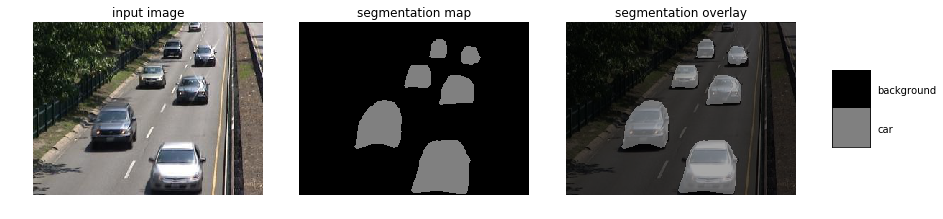

In [15]:
def run_visualization_local(img_path):
    """Inferences DeepLab model and visualizes result."""
    try:
        orignal_im = Image.open(img_path)
    except IOError:
        print('Cannot retrieve image. Please check path: ' + img_path)
        return

    print('running deeplab on image %s...' % img_path)
    resized_im, seg_logits, seg_map = MODEL.run(orignal_im)
    print('seg_logits.shape: ',seg_logits.shape)
    print('seg_map.shape: ',seg_map.shape)
    
    vis_segmentation(resized_im, seg_map)

img_path = 'image2.jpg'
run_visualization_local(img_path)
resized_im, seg_logits, seg_map = MODEL.run(Image.open(img_path))

## 2.2. Check Logits

In [16]:
import cv2

In [17]:
seg_logits_channel_sum = np.sum(seg_logits,axis=-1)
seg_logits_channel_sum_tile = np.dstack([seg_logits_channel_sum for i in range(seg_logits.shape[-1])])
seg_logits_normalized = seg_logits/seg_logits_channel_sum_tile

In [18]:
for i in range(seg_logits_normalized.shape[-1]):
    cv2.imshow('seg_logits_normalized',seg_logits_normalized[:240,:320,i])
    cv2.waitKey(-1)
cv2.destroyAllWindows()

# 3. Build model upon both results

In [17]:
top_graph = tf.Graph()
top_session = tf.Session(graph=top_graph)

In [18]:
with top_graph.as_default():
    input_compatibility = tf.placeholder(tf.float32,shape=[image_height,image_width],name='raw_segmentation')
    input_logits = tf.placeholder(tf.float32,shape=[image_height,image_width,21],name='semantic_logits')
    input_truth = tf.placeholder(tf.float32,shape=[image_height,image_width],name='ground_truth')
    input_weight = tf.placeholder(tf.float32,shape=[image_height,image_width],name='training_weight')

In [19]:
with top_graph.as_default():
    feature_map_0 = tf.expand_dims(tf.concat([tf.expand_dims(input_compatibility,axis=-1),input_logits],
                                             axis=-1),
                                   axis=0,name='feature_map_0')
    feature_map_1 = tf.contrib.slim.conv2d(feature_map_0, 512, [1,1],
                                           activation_fn=tf.nn.relu, 
                                           normalizer_fn=None, 
                                           padding='SAME', 
                                           scope='feature_map_1')
    feature_map_2 = tf.contrib.slim.conv2d(feature_map_1, 1, [1,1],
                                           activation_fn=None, 
                                           normalizer_fn=None, 
                                           padding='SAME', 
                                           scope='feature_map_2')

In [20]:
with top_graph.as_default():
    loss = tf.reduce_mean(tf.nn.weighted_cross_entropy_with_logits(logits=tf.squeeze(feature_map_2), 
                                                                   targets=input_truth,
                                                                   pos_weight=input_weight), 
                          name='calculate_weighted_loss')
    optimizer = tf.train.AdamOptimizer(0.0001).minimize(loss, var_list=[var for var in tf.trainable_variables()])
    tf.summary.FileWriter('Logs', top_graph)

In [21]:
with top_graph.as_default():
    for var in tf.trainable_variables():
        print(var)

<tf.Variable 'feature_map_1/weights:0' shape=(1, 1, 22, 512) dtype=float32_ref>
<tf.Variable 'feature_map_1/biases:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'feature_map_2/weights:0' shape=(1, 1, 512, 1) dtype=float32_ref>
<tf.Variable 'feature_map_2/biases:0' shape=(1,) dtype=float32_ref>


# 4. Training on a piece of sequence

In [22]:
truth_folder = 'F:\\dataset2014\\dataset\\baseline\\highway\\groundtruth\\'

In [23]:
with top_graph.as_default():
    top_session.run(tf.global_variables_initializer())

In [24]:
for i_train in range(500,500+200):
    # Load image
    cv_BGR_image = cv2.imread(image_folder + 'in{0:06d}'.format(i_train) + '.jpg')
    # Calculate SS result
    Image_image = Image.open(image_folder + 'in{0:06d}'.format(i_train) + '.jpg')
    _, seg_logits, _ = MODEL.run(Image_image)
    seg_logits_channel_sum = np.sum(seg_logits,axis=-1)
    seg_logits_channel_sum_tile = np.dstack([seg_logits_channel_sum for i in range(seg_logits.shape[-1])])
    seg_logits_normalized = seg_logits/seg_logits_channel_sum_tile
    cv2.imshow('seg_map',seg_logits_normalized[:240,:320,0])
    # Transform BGR image
    cv_gray_image = cv2.cvtColor(cv_BGR_image, cv2.COLOR_BGR2GRAY)
    cv_float_gray_image = cv_gray_image.astype('float')/256.0 # Avoid reaching the 22th bin of a histogram (not using ./255)
    cv2.imshow('cv_float_gray_image',cv_float_gray_image)
    # Load the groundtruth
    cv_BGR_truth = cv2.imread(truth_folder + 'gt{0:06d}'.format(i_train) + '.png')
    cv_gray_truth = cv2.cvtColor(cv_BGR_truth, cv2.COLOR_BGR2GRAY)
    cv_float_gray_truth = 1.0-cv_gray_truth.astype('float')/255.0 
    cv2.imshow('cv_float_gray_truth',cv_float_gray_truth)
    # Calculate loss weight (HAVE PROBLEM!!!)
    cv_gray_weight = cv_gray_truth.astype('float')/255.0 
    weight_index_object = np.where(cv_gray_weight==1.0)
    weight_index_background = np.where(cv_gray_weight==0.0)
    weight_index_other = np.where((cv_gray_weight<1.0)&(cv_gray_weight>0.0))
    cv_gray_weight[weight_index_object] = 1.0
    cv_gray_weight[weight_index_background] = 0.1
    cv_gray_weight[weight_index_other] = 0.0
    cv2.imshow('cv_gray_weight',cv_gray_weight)
    # FH segmentation
    raw_segmentation = FH_MODEL.histogram_checking(cv_float_gray_image)
    cv2.imshow('raw_segmentation',raw_segmentation)
    fake_synthesis = FH_MODEL.fake_synthesis_generate(raw_segmentation)
    cv2.imshow('fake_synthesis_image',fake_synthesis)
    FH_MODEL.update_histogram(cv_float_gray_image,fake_synthesis,train_flag=False)
    # Learning
    with top_graph.as_default():
        _, current_loss,synthesis_raw = top_session.run([optimizer,loss,feature_map_2],
                                                        feed_dict={input_compatibility:raw_segmentation, 
                                                                   input_logits: seg_logits_normalized[:240,:320,:], 
                                                                   input_truth: cv_float_gray_truth,
                                                                   input_weight: cv_gray_weight})
        print('i_train: ',i_train,'current_loss:',current_loss)
    synthesis_result = 1/(1+np.exp(-np.squeeze(synthesis_raw)))
    cv2.imshow('synthesis_result',synthesis_result)
    cv2.waitKey(-1)
    #fake_synthesis = FH_MODEL.fake_synthesis_generate(raw_segmentation)
    #cv2.imshow('synthesis_image',fake_synthesis)
    #cv2.waitKey(50)
    #FH_MODEL.update_histogram(cv_float_gray_image,fake_synthesis,train_flag=True)

i_train:  500 current_loss: 0.07004682
i_train:  501 current_loss: 0.069880694
i_train:  502 current_loss: 0.069678545
i_train:  503 current_loss: 0.06943981
i_train:  504 current_loss: 0.0692412
i_train:  505 current_loss: 0.06898122
i_train:  506 current_loss: 0.06877604
i_train:  507 current_loss: 0.068550915
i_train:  508 current_loss: 0.068394445
i_train:  509 current_loss: 0.06825961
i_train:  510 current_loss: 0.06800312
i_train:  511 current_loss: 0.06773147
i_train:  512 current_loss: 0.0676407
i_train:  513 current_loss: 0.06736341
i_train:  514 current_loss: 0.06709252
i_train:  515 current_loss: 0.06698741
i_train:  516 current_loss: 0.06690457
i_train:  517 current_loss: 0.06661388
i_train:  518 current_loss: 0.06640141
i_train:  519 current_loss: 0.06628
i_train:  520 current_loss: 0.06604832
i_train:  521 current_loss: 0.06562725
i_train:  522 current_loss: 0.065212235
i_train:  523 current_loss: 0.06506836
i_train:  524 current_loss: 0.06486315
i_train:  525 current_los

In [25]:
cv2.destroyAllWindows()

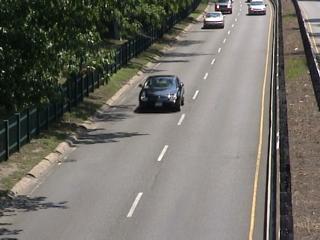

In [41]:
Image_image

In [44]:
Image_image = Image.open(image_folder + 'in{0:06d}'.format(650) + '.jpg')
_, seg_logits, seg_map = MODEL.run(Image_image)
cv2.imshow('seg_map',seg_map*255)

In [45]:
cv2.waitKey(-1)

32

In [28]:
np.exp([6,4])

array([403.42879349,  54.59815003])

In [80]:
temp_arr = np.array([[1.0,0.9,0.5,0.0],[0.1,0.2,0.0,1.0]])
print(temp_arr)
temp_index_1 = np.where((temp_arr==1.0) | (temp_arr==0.0))
print(temp_index_1)
temp_index_2 = np.where((temp_arr<1.0) & (temp_arr>0.0))
print(temp_index_2)
temp_arr[temp_index_1] = 1.0
temp_arr[temp_index_2] = 0.0
print(temp_arr)

[[1.  0.9 0.5 0. ]
 [0.1 0.2 0.  1. ]]
(array([0, 0, 1, 1], dtype=int64), array([0, 3, 2, 3], dtype=int64))
(array([0, 0, 1, 1], dtype=int64), array([1, 2, 0, 1], dtype=int64))
[[1. 0. 0. 1.]
 [0. 0. 1. 1.]]


In [73]:
temp_arr = np.array([[1.0,0.9,0.5,0.0],[0.1,0.2,0.0,1.0]])
# temp_arr = np.array([1.0,0.9,0.5,0.0])

In [75]:
np.where((temp_arr<1.0) & (temp_arr>0.0))

(array([0, 0, 1, 1], dtype=int64), array([1, 2, 0, 1], dtype=int64))

In [78]:
temp_arr[np.where((temp_arr<1.0) & (temp_arr>0.0))] = 0.0

In [79]:
temp_arr

array([[1., 0., 0., 0.],
       [0., 0., 0., 1.]])

In [56]:
tuple(np.concatenate([np.where(temp_arr<1.0),np.where(temp_arr>0.0)],axis=-1))

(array([0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1], dtype=int64),
 array([1, 2, 3, 0, 1, 2, 0, 1, 2, 0, 1, 3], dtype=int64))

In [72]:
np.array(np.where(temp_arr<1.0)) == np.array(np.where(temp_arr>0.0))

array([[ True,  True,  True,  True,  True,  True],
       [False, False, False,  True,  True, False]])

In [60]:
np.array(list(np.where(temp_arr<1.0))).T

array([[0, 1],
       [0, 2],
       [0, 3],
       [1, 0],
       [1, 1],
       [1, 2]], dtype=int64)

In [61]:
np.array(list(np.where(temp_arr>0.0))).T

array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 3]], dtype=int64)

In [67]:
np.unique(np.concatenate([np.array(list(np.where(temp_arr<1.0))).T,np.array(list(np.where(temp_arr>0.0))).T]),axis=0)

array([[0, 0],
       [0, 1],
       [0, 2],
       [0, 3],
       [1, 0],
       [1, 1],
       [1, 2],
       [1, 3]], dtype=int64)

In [37]:
np.where(temp_arr==1.0)

(array([0, 1], dtype=int64), array([0, 3], dtype=int64))

In [38]:
np.where(temp_arr==0.0)

(array([0, 1], dtype=int64), array([3, 2], dtype=int64))

In [50]:
np.concatenate([np.where(temp_arr==1.0),np.where(temp_arr==0.0)],axis=-1)

array([[0, 1, 0, 1],
       [0, 3, 3, 2]], dtype=int64)

In [51]:
tuple(np.concatenate([np.where(temp_arr==1.0),np.where(temp_arr==0.0)],axis=-1))

(array([0, 1, 0, 1], dtype=int64), array([0, 3, 3, 2], dtype=int64))

In [52]:
temp_arr[tuple(np.concatenate([np.where(temp_arr==1.0),np.where(temp_arr==0.0)],axis=-1))]

array([1., 1., 0., 0.])

In [53]:
temp_arr[tuple(np.concatenate([np.where(temp_arr==1.0),np.where(temp_arr==0.0)],axis=-1))] = 1.0

In [54]:
temp_arr

array([[1. , 0.9, 0.5, 1. ],
       [0.1, 0.2, 1. , 1. ]])